In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from datagen import DataGenerator

## Data generator

In [2]:
def prepare_data(num_samples=1000, signal_length=100, seed=None):
    generator = DataGenerator(signal_length=signal_length, seed=seed)

    # Generate full dataset
    X_jump, (y_amp_jump, y_cp_jump) = generator.generate_data(num_samples // 2, jump=True)
    y_jump_indicator = torch.ones_like(y_cp_jump)
    X_const, (y_amp_const, y_cp_const) = generator.generate_data(num_samples // 2, jump=False)
    y_const_indicator = torch.zeros_like(y_cp_const)

    # Convert everything to float32 explicitly
    X = torch.cat([X_jump, X_const], dim=0).float()
    y_amp = torch.cat([y_amp_jump, y_amp_const], dim=0).float()
    y_cp = torch.cat([y_cp_jump, y_cp_const], dim=0).float().unsqueeze(1)
    y_indicator = torch.cat([y_jump_indicator, y_const_indicator], dim=0).float().unsqueeze(1)
    print(y_amp.shape, y_cp.shape, y_indicator.shape)

    # Shuffle dataset
    indices = torch.randperm(num_samples)
    X, y_amp, y_cp, y_indicator = X[indices], y_amp[indices], y_cp[indices], y_indicator[indices]

    return X, y_indicator, y_cp, y_amp

In [3]:
def prepare_ground_truth(jump_positions, n_bins=64, signal_length=1024):
    """
    Args:
        jump_positions: List of jump positions (in samples) for each signal. Use -1 for no jump.
        n_bins: Number of bins for position prediction.
        signal_length: Length of the input signal.
    Returns:
        gt_pos: Tensor of shape [batch_size] (bin index of jump, or 0 if no jump).
    """
    batch_size = len(jump_positions)
    gt_pos = torch.zeros(batch_size, dtype=torch.long)
    
    bin_size = signal_length // n_bins
    
    for i, pos in enumerate(jump_positions):
        if pos >= 0:  # Jump exists
            gt_pos[i] = min(pos // bin_size, n_bins - 1)  # Ensure bin index is within range
        else:  # No jump
            gt_pos[i] = 0  # Irrelevant, since loss will be masked
    
    return gt_pos

In [4]:
def prepare_dataloaders(num_samples=1000, signal_length=1024, batch_size=32, train_ratio=0.8, n_bins=64, seed=None):
    
    X, y_indicator, y_cp, y_amp = prepare_data(num_samples, signal_length, seed)

    y_cp = prepare_ground_truth(y_cp, n_bins, signal_length)

    num_samples = X.shape[0]
    # Train/validation split
    train_size = int(train_ratio * num_samples)
    val_size = num_samples - train_size
    
    X_train = X[:train_size]
    X_val = X[train_size:]
    y_indicator_train = y_indicator[:train_size]
    y_indicator_val = y_indicator[train_size:]
    y_cp_train = y_cp[:train_size]
    y_cp_val = y_cp[train_size:]
    y_amp_train = y_amp[:train_size]
    y_amp_val = y_amp[train_size:]


    # Create datasets and dataloaders
    train_dataset = TensorDataset(X_train, y_indicator_train, y_cp_train, y_amp_train)
    val_dataset = TensorDataset(X_val, y_indicator_val, y_cp_val, y_amp_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [5]:
train_loader, val_loader = prepare_dataloaders(batch_size=256, signal_length=1024, seed=42, num_samples=50_000)

torch.Size([50000, 4]) torch.Size([50000, 1]) torch.Size([50000, 1])


In [6]:
dummy_data = next(iter(train_loader))
dummy_data

[tensor([[[  128.9844, -2362.7139, -1459.9290,  ..., -2437.4631,
            -418.7927, -1157.3844],
          [ 1056.9888,  -727.7728,  2172.7349,  ...,    67.7678,
             858.4960,  2347.1743]],
 
         [[-2390.9436, -1202.0691, -1325.5686,  ..., -1055.2358,
            -599.0897, -1452.9836],
          [  618.1628,  2084.3911,  2036.7823,  ...,   720.4336,
            1206.6832, -1961.8562]],
 
         [[-3103.1084,    10.3209,   225.3537,  ...,  1528.3220,
            -596.1711,  1947.2322],
          [-3144.9407, -1485.0723,  1882.6914,  ...,   590.9350,
           -1248.7214,   806.9880]],
 
         ...,
 
         [[ 1068.6527,   453.6537, -2823.7739,  ...,  1433.8257,
            2354.7148,  2612.2007],
          [  712.9173,   118.7017,  -926.3109,  ...,  1354.1694,
             360.2656,  1663.5945]],
 
         [[ 1565.4348,  -810.1088,   188.5870,  ...,  1010.5414,
            -417.1766,   814.1782],
          [  -92.6525, -1011.6904, -2139.6243,  ..., -3194.3889

## Model

In [7]:
class JumpAmplitudeModel(nn.Module):
    def __init__(self, signal_length=1024, n_bins=64):
        super().__init__()
        self.n_bins = n_bins
        self.bin_size = signal_length // n_bins
        
        # Feature extractor with dilated convolutions
        self.features = nn.Sequential(
            nn.Conv1d(2, 16, kernel_size=5, padding=2, dilation=1),
            nn.InstanceNorm1d(16),
            nn.ReLU(),
            
            nn.Conv1d(16, 32, kernel_size=5, padding=4, dilation=2),
            nn.InstanceNorm1d(32),
            nn.ReLU(),
            
            nn.Conv1d(32, 64, kernel_size=5, padding=8, dilation=4),
            nn.InstanceNorm1d(64),
            nn.ReLU(),
        )
        
        # Jump probability head
        self.jump_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),  # [batch, 64, 1]
            nn.Flatten(),             # [batch, 64]
            nn.Linear(64, 1),         # [batch, 1]
            nn.Sigmoid()              # [batch, 1]
        )
        
        # Position probability head
        self.pos_head = nn.Sequential(
            nn.Conv1d(64, n_bins, kernel_size=1),  # [batch, n_bins, signal_length]
            nn.AdaptiveAvgPool1d(1),              # [batch, n_bins, 1]
            nn.Flatten(start_dim=1),              # [batch, n_bins]
            nn.Softmax(dim=1)                     # [batch, n_bins]
        )
        
    def forward(self, x):
        # Feature extraction
        features = self.features(x)  # [batch, 64, signal_length]
        
        # Jump probability
        jump_p = self.jump_head(features)  # [batch, 1]
        
        # Position probabilities
        pos_probs = self.pos_head(features)  # [batch, n_bins]
        
        return jump_p, pos_probs

## Training functionality

In [8]:
def train_epoch(model, dataloader, optimizer, device, criterion):
    model.train()
    total_loss = 0
    loss_percentages = {"jump_loss": 0.0, "pos_loss": 0.0, "amp_loss": 0.0, "entropy_loss": 0.0}

    for X, y_indicator, y_cp, y_amp in dataloader:
        X, y_indicator, y_cp, y_amp = X.to(device), y_indicator.to(device), y_cp.to(device), y_amp.to(device)

        jump_p, pos_probs = model(X)
        pred = (jump_p, pos_probs)

        gt = (y_indicator.squeeze(), y_cp.squeeze(), y_amp[:,0], y_amp[:,1], y_amp[:,2], y_amp[:,3])

        bin_size = X.size(2) // pos_probs.size(1)  # signal_length // n_bins
        loss = criterion(pred, gt, X, bin_size)

        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def validate(model, dataloader, device, criterion):
    model.eval()
    total_loss = 0

    for X, y_indicator, y_cp, y_amp in dataloader:
        X, y_indicator, y_cp, y_amp = X.to(device), y_indicator.to(device), y_cp.to(device), y_amp.to(device)

        jump_p, pos_probs = model(X)
        pred = (jump_p, pos_probs)

        gt = (y_indicator.squeeze(), y_cp.squeeze(), y_amp[:,0], y_amp[:,1], y_amp[:,2], y_amp[:,3])

        bin_size = X.size(2) // pos_probs.size(1)  # signal_length // n_bins
        loss = criterion(pred, gt, X, bin_size)
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [9]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    loss_fn,
    num_epochs=20,
    plot_loss=True,
    scheduler=None
):
    """
    Train the model and track performance metrics.

    Args:
        model (nn.Module): Model to train.
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        optimizer (Optimizer): Optimizer.
        device (torch.device): Device to run on (CPU/GPU).
        amp_loss_fn (Loss): Loss function for amplitude regression.
        cp_loss_fn (Loss): Loss function for change point localization.
        num_epochs (int): Number of training epochs.
        plot_loss (bool): Whether to plot loss curves.

    Returns:
        trained_model (nn.Module): Best trained model.
    """
    best_val_loss = float("inf")
    best_model_wts = model.state_dict()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        train_loss = train_epoch(
            model, train_loader, optimizer, device, loss_fn
        )
        val_loss = validate(model, val_loader, device, loss_fn)

        if scheduler:
            scheduler.step(val_loss)
            print(scheduler.get_last_lr())

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    print("Training complete. Best Val Loss: {:.4f}".format(best_val_loss))

    if plot_loss:
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
        plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()
        plt.show()

    return model

In [10]:
def compute_amplitudes(x, pos_probs, bin_size):
    """
    Args:
        x: Input signal of shape [batch_size, 2, signal_length]
        pos_probs: Position probabilities of shape [batch_size, n_bins]
        bin_size: Size of each bin (signal_length // n_bins)
    Returns:
        start_i: [batch_size] (start in-phase amplitude)
        start_q: [batch_size] (start quadrature amplitude)
        stop_i: [batch_size] (stop in-phase amplitude)
        stop_q: [batch_size] (stop quadrature amplitude)
    """
    batch_size, n_bins = pos_probs.shape
    signal_length = x.size(2)
    device = x.device

    # Compute cumulative sums for efficient mean calculation
    cumsum_i = torch.cumsum(x[:, 0, :], dim=1)  # [batch_size, signal_length]
    cumsum_q = torch.cumsum(x[:, 1, :], dim=1)  # [batch_size, signal_length]

    # Precompute all possible split points
    split_points = torch.arange(0, n_bins, device=device) * bin_size  # [n_bins]
    split_points = split_points.unsqueeze(0).repeat(batch_size, 1)  # [batch_size, n_bins]

    # Compute means for all possible splits
    means_i = torch.zeros(batch_size, n_bins, 2, device=device)  # [start, stop]
    means_q = torch.zeros_like(means_i)

    for i in range(n_bins):
        t = split_points[:, i]  # [batch_size]
        t = torch.clamp(t, 1, signal_length - 1)  # Avoid division by zero

        # Start means
        means_i[:, i, 0] = cumsum_i.gather(1, t.long().unsqueeze(1)).squeeze() / t
        means_q[:, i, 0] = cumsum_q.gather(1, t.long().unsqueeze(1)).squeeze() / t

        # Stop means
        means_i[:, i, 1] = (cumsum_i[:, -1] - cumsum_i.gather(1, t.long().unsqueeze(1)).squeeze()) / (signal_length - t)
        means_q[:, i, 1] = (cumsum_q[:, -1] - cumsum_q.gather(1, t.long().unsqueeze(1)).squeeze()) / (signal_length - t)

    # Weight by position probabilities
    weighted_start_i = (means_i[..., 0] * pos_probs).sum(dim=1)  # [batch_size]
    weighted_stop_i = (means_i[..., 1] * pos_probs).sum(dim=1)  # [batch_size] 
    weighted_start_q = (means_q[..., 0] * pos_probs).sum(dim=1)  # [batch_size]
    weighted_stop_q = (means_q[..., 1] * pos_probs).sum(dim=1)  # [batch_size] 

    return weighted_start_i, weighted_start_q, weighted_stop_i, weighted_stop_q

In [12]:
class CustomLoss(nn.Module):
    def __init__(self, pos_weight=1.0, amp_weight=1.0, entropy_weight=0.1):
        super().__init__()
        self.bce = nn.BCELoss()  # For jump classification
        self.ce = nn.CrossEntropyLoss()  # For position prediction
        self.amp_loss = nn.SmoothL1Loss()  # For amplitude regression
        self.pos_weight = pos_weight
        self.amp_weight = amp_weight
        self.entropy_weight = entropy_weight

    def forward(self, pred, gt, x, bin_size):
        jump_p, pos_probs = pred
        gt_jump, gt_pos, gt_start_i, gt_start_q, gt_stop_i, gt_stop_q = gt

        # Jump classification loss
        jump_loss = self.bce(jump_p.squeeze(), gt_jump.float())

        # Position loss (only when jump exists)
        mask = gt_jump.bool()  # Mask for samples with jumps
        if mask.any():
            pos_loss = self.ce(pos_probs[mask], gt_pos[mask])
        else:
            pos_loss = torch.tensor(0.0, device=jump_p.device)

        # Amplitude loss
        start_i, start_q, stop_i, stop_q = compute_amplitudes(x, pos_probs, bin_size)
        amp_loss = self.amp_loss(
            torch.vstack([start_i, start_q, stop_i, stop_q]),
            torch.vstack([gt_start_i, gt_start_q, gt_stop_i, gt_stop_q])
        )

        # Entropy regularization (only when jump exists)
        entropy = -torch.sum(pos_probs * torch.log(pos_probs + 1e-10), dim=1)  # [batch_size]
        entropy_loss = (entropy * gt_jump).mean()  # Apply only to samples with jumps

        # Combine losses
        total_loss = (
            jump_loss +
            self.pos_weight * pos_loss +
            self.amp_weight * amp_loss +
            self.entropy_weight * entropy_loss
        )

        # Compute percentage contributions
        loss_components = {
            "jump_loss": jump_loss.item(),
            "pos_loss": pos_loss.item() * self.pos_weight,
            "amp_loss": amp_loss.item() * self.amp_weight,
            "entropy_loss": entropy_loss.item() * self.entropy_weight,
        }
        total = sum(loss_components.values())
        loss_percentages = {k: (v / total) * 100 for k, v in loss_components.items()}

        return total_loss, loss_percentages

In [13]:
a = torch.arange(10).reshape(2,5)
a, torch.cumsum(a, dim=1)

(tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]),
 tensor([[ 0,  1,  3,  6, 10],
         [ 5, 11, 18, 26, 35]]))

In [14]:
b = torch.Tensor([0, 16, 32, 48, 64])
split_points = b.unsqueeze(0).repeat(4, 1)  # [4, n_bins]
split_points

tensor([[ 0., 16., 32., 48., 64.],
        [ 0., 16., 32., 48., 64.],
        [ 0., 16., 32., 48., 64.],
        [ 0., 16., 32., 48., 64.]])

In [15]:
t = split_points[:, 0]
t

tensor([0., 0., 0., 0.])

In [16]:
t = torch.clamp(t, 1, 80 - 1)
t

tensor([1., 1., 1., 1.])

## Train

In [35]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize model and loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = JumpAmplitudeModel().to(device)
criterion = CustomLoss(pos_weight=1.0, amp_weight=1.0, entropy_weight=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)


cuda


[0.01]
Epoch [1/300]  Train Loss: 119.4858  Val Loss: 119.3340
[0.01]
Epoch [2/300]  Train Loss: 116.8682  Val Loss: 117.4303
[0.01]
Epoch [3/300]  Train Loss: 115.3864  Val Loss: 116.2931
[0.01]
Epoch [4/300]  Train Loss: 114.4012  Val Loss: 115.8731
[0.01]
Epoch [5/300]  Train Loss: 113.9605  Val Loss: 115.5331
[0.01]
Epoch [6/300]  Train Loss: 113.0905  Val Loss: 114.4941
[0.01]
Epoch [7/300]  Train Loss: 112.5401  Val Loss: 114.1092
[0.01]
Epoch [8/300]  Train Loss: 112.2500  Val Loss: 113.6942
[0.01]
Epoch [9/300]  Train Loss: 111.9796  Val Loss: 113.1364
[0.01]
Epoch [10/300]  Train Loss: 111.5899  Val Loss: 113.2030
[0.01]
Epoch [11/300]  Train Loss: 111.4372  Val Loss: 112.6757
[0.01]
Epoch [12/300]  Train Loss: 111.0873  Val Loss: 112.7431
[0.01]
Epoch [13/300]  Train Loss: 110.7079  Val Loss: 111.8972
[0.01]
Epoch [14/300]  Train Loss: 109.8977  Val Loss: 110.6572
[0.01]
Epoch [15/300]  Train Loss: 109.0140  Val Loss: 109.4856
[0.01]
Epoch [16/300]  Train Loss: 107.2299  Val 

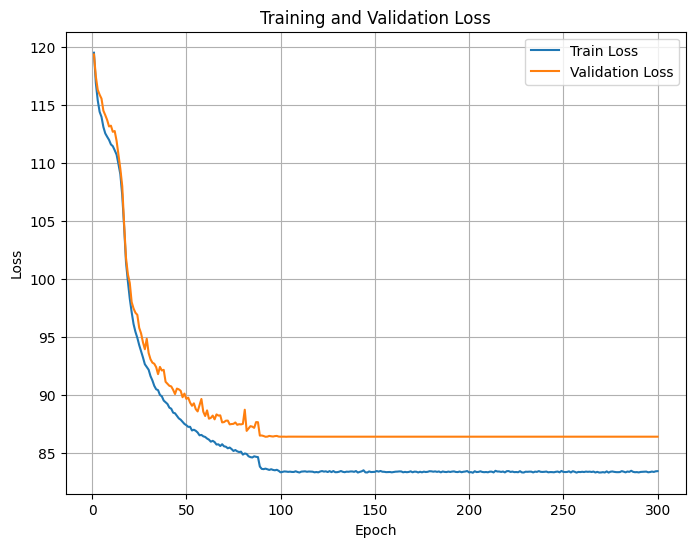

In [36]:
trained_model1 = train_model(
        model,
        train_loader,
        val_loader,
        optimizer,
        device,
        criterion,
        num_epochs=300,
        scheduler=scheduler
    )

In [37]:
test_dummy = next(iter(val_loader))
test_dummy

[tensor([[[ 2102.2769,   407.7083,   170.0623,  ...,  -898.3487,
           -2779.2090,  -816.0172],
          [-2056.9741,  2940.7517,  1271.7192,  ..., -1243.4318,
           -2281.5813, -2420.2747]],
 
         [[  -12.9912,  -236.6904,   -77.3014,  ..., -1330.9393,
            -317.2576,   305.1830],
          [  567.3638, -3496.4246,   -89.3775,  ...,  -790.9786,
           -2254.7686, -1884.8403]],
 
         [[ 5115.2349,   499.6626,   948.3342,  ...,  -529.3042,
             712.9390,  1056.0459],
          [  732.2154,  1106.1027,  3165.0308,  ...,   296.9810,
             508.7326,   -70.4058]],
 
         ...,
 
         [[  172.2278,   223.4360, -1102.0370,  ...,   328.7923,
            -100.4184, -2901.3333],
          [  429.5121,  2465.8386, -1451.0809,  ...,   360.3534,
            3942.1348,   131.3292]],
 
         [[  -60.4660, -1853.9871, -2994.9580,  ...,  2161.3457,
            2394.0864, -2965.7480],
          [-1313.1956,  -321.1489, -4373.6396,  ...,     7.8354

In [38]:
test_dummy[3]

tensor([[ 153.7832,  163.4942, -922.1494, -952.9467],
        [-399.5777, -869.5340,  394.2289,  136.9625],
        [ 445.8357,  -15.3292,  445.8357,  -15.3292],
        ...,
        [-454.0664,  364.9399, -481.5957,  331.9081],
        [ -56.7942, -234.2085, -579.2318, -156.2706],
        [  17.9769,  196.2753,  354.4303, -854.1609]])

In [39]:
pred = trained_model1(test_dummy[0].to(device))

In [40]:
loss = torch.nn.BCELoss()
loss(test_dummy[1], torch.round(pred[0]).to("cpu"))

tensor(14.0625, grad_fn=<BinaryCrossEntropyBackward0>)

In [41]:
from torchmetrics.functional import accuracy
accuracy(test_dummy[1], torch.round(pred[0]).to("cpu"), task="binary")

tensor(0.8594)

In [38]:
compute_amplitudes(test_dummy[0], torch.round(pred[1]).to("cpu"), 16)[0]

tensor([ 1.9736e+02,  0.0000e+00,  0.0000e+00,  6.0725e+02,  8.3568e+02,
         5.8925e+02,  1.9452e+02, -8.4051e+02, -7.3593e+02, -3.0441e+02,
        -5.6188e+02,  4.9607e+02, -5.4266e+02, -7.6442e+01, -4.9627e+02,
        -8.6523e+02, -6.1714e+01, -9.7069e+02, -2.0469e+01,  5.9362e+02,
         0.0000e+00,  6.1139e+02,  1.0162e+03,  0.0000e+00,  3.5237e+01,
        -5.2420e+02, -3.5259e+02,  0.0000e+00,  1.0360e+03,  1.8568e+02,
        -1.4446e+02,  4.5778e+02, -7.7671e+02,  7.8626e+02,  4.4416e+02,
         0.0000e+00,  0.0000e+00, -3.0204e+02,  0.0000e+00,  6.1407e+02,
        -8.4785e+02,  5.8763e+02, -6.6218e+02, -5.8633e+02,  7.3092e+02,
         7.2447e+02,  2.2453e+02,  5.3550e+02, -7.0271e+02,  2.3558e+02,
        -9.7118e+02,  0.0000e+00,  0.0000e+00, -7.1487e+02,  3.0978e+02,
         3.3180e+02, -1.6380e+02,  1.2399e+02,  0.0000e+00,  3.9770e+02,
        -7.7099e+02, -6.6387e+02,  3.6458e+02, -6.7718e+01, -5.2847e+02,
        -6.1017e+01,  2.3295e+02,  0.0000e+00, -4.9